In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from sklearn.metrics import mean_squared_error, r2_score

# 시각화에서 한글이 깨지는 문제 해결
mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('942번 대여소 일별 데이터셋.xlsx', index_col=0)

In [3]:
# 타겟값인 다음날 8시 거치수량을 예측하기 위해 변화량을 예측 후 예측한 변화량을 15시 거치수량에 더함
# y값으로 사용할 변화량 변수 생성
df['변화량'] = df['다음날 8시 거치수량'] - df['15시 거치수량']
# 불필요한 변수 제거
df.drop(['일시'], axis=1, inplace=True)

### 데이터 전처리

<Axes: >

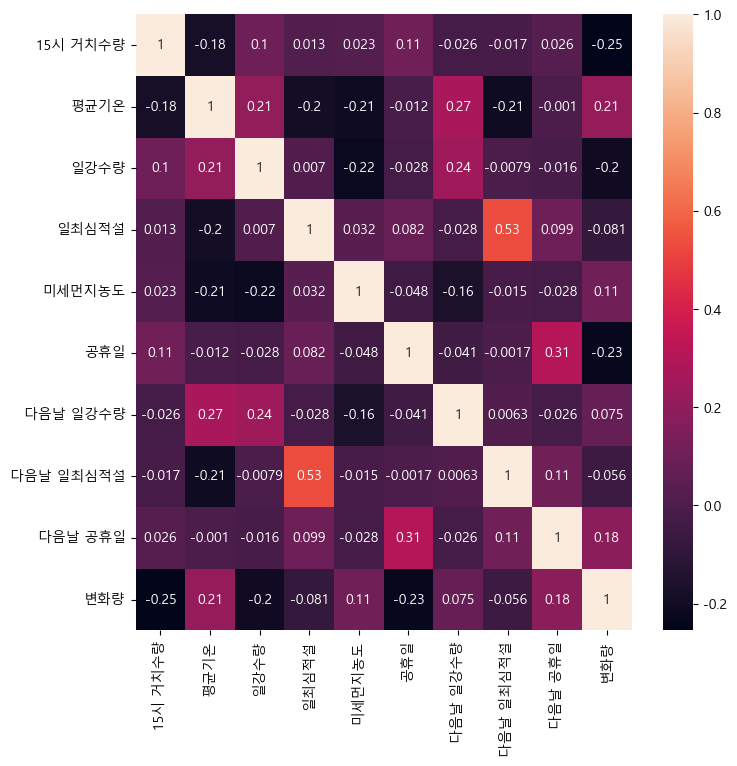

In [24]:
# 변수 간 상관관계를 분석하여 상관관계가 높은 경우는 하나의 변수만 선택하여 다중공선성을 감소 (다중공선성이 높아지면 예측 모델의 p-value에 악영향을 줌)
plt.figure(figsize=(8, 8))
sns.heatmap(data=df.corr(), annot=True)

In [4]:
# 상관관계가 높은 변수 제거
# 평균기온, 다음날 평균기온 → 평균기온만 사용
# 미세먼지농도, 초미세먼지농도, 다음날 미세먼지농도, 다음날 초미세먼지농도 → 미세먼지농도만 사용
df.drop(['다음날 평균기온', '초미세먼지농도', '다음날 미세먼지농도', '다음날 초미세먼지농도'], axis=1, inplace=True)

ValueError: num must be an integer with 1 <= num <= 10, not 11

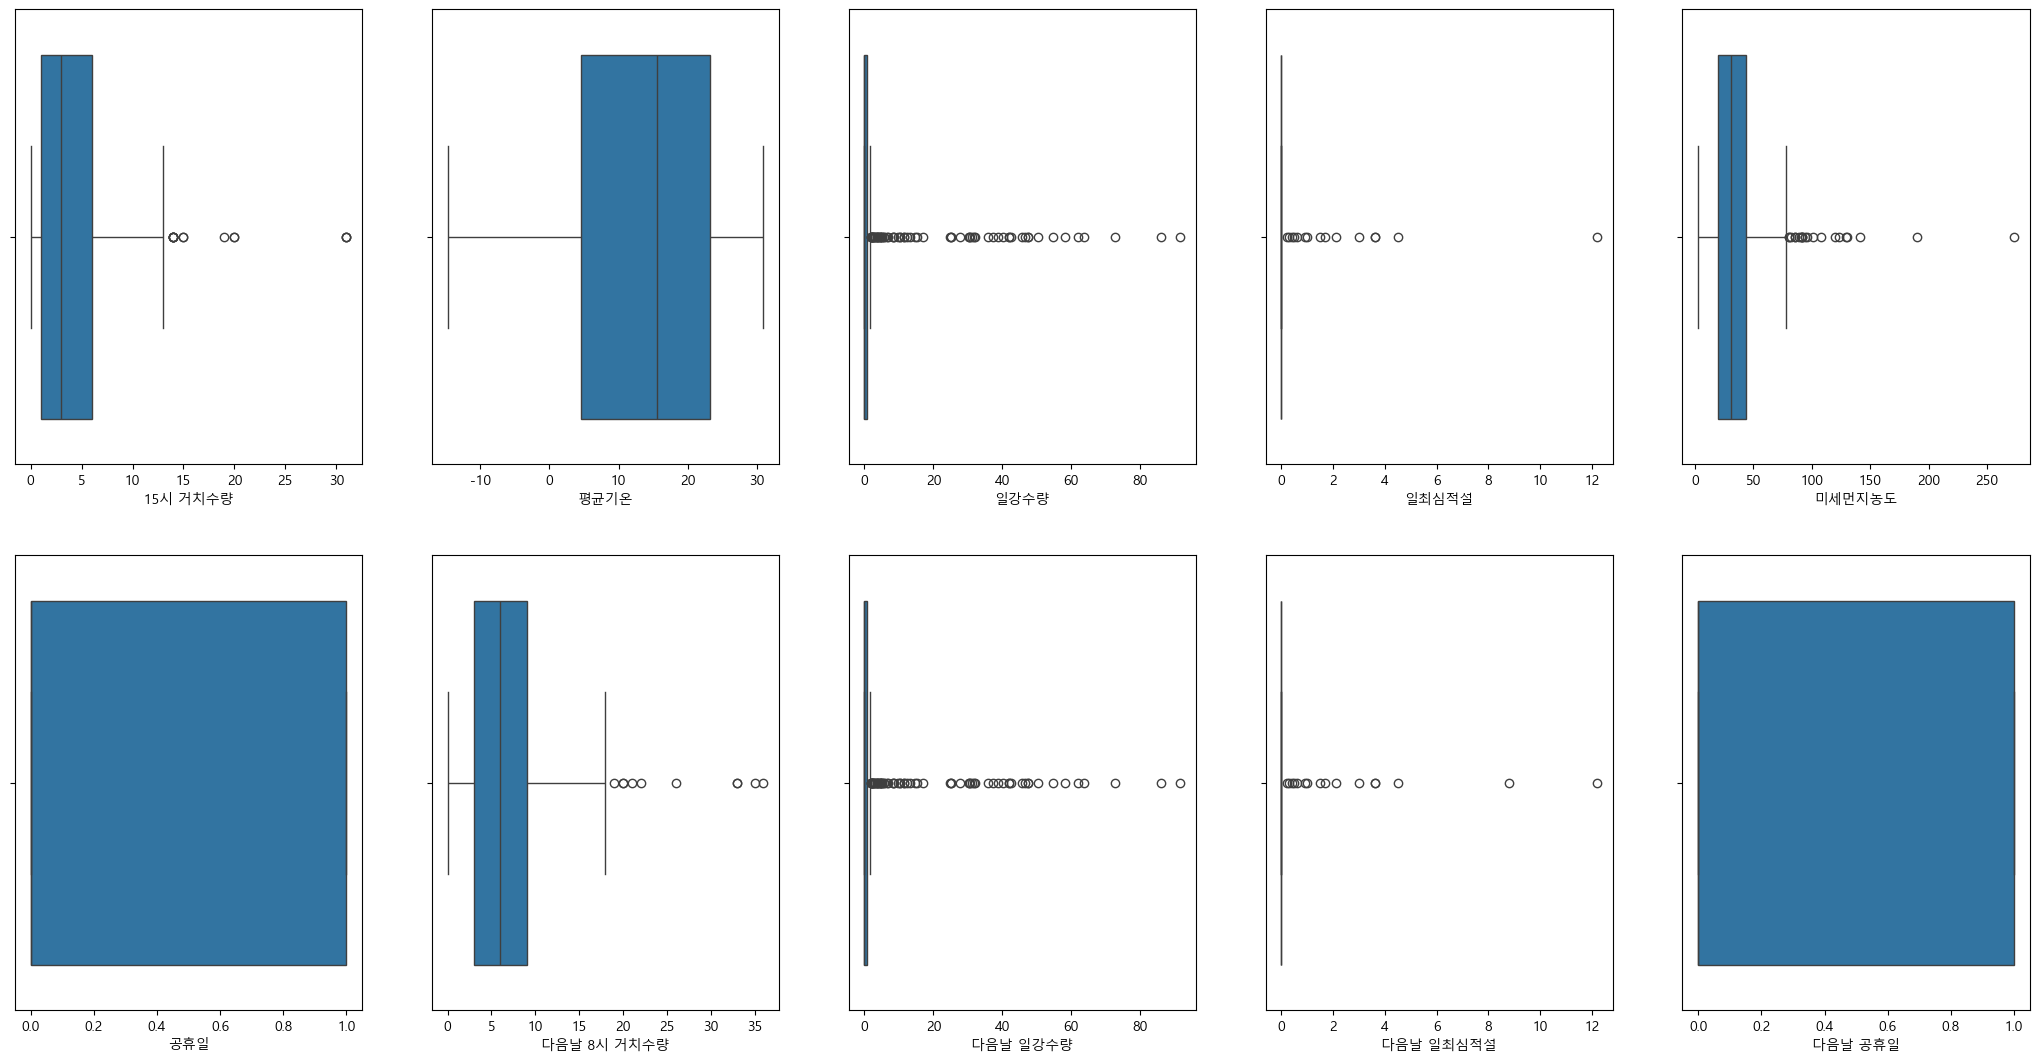

In [41]:
# 변수별 이상치 확인
plt.figure(figsize=(26,13))
for i, c in enumerate(df.columns):
    plt.subplot(2, 5, i + 1)
    sns.boxplot(data=df, x=c)
plt.show()

In [5]:
# 데이터프레임에서 컬럼별로 이상치가 있는 데이터를 확인하는 함수
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# 일강수량 구간화 함수
def binning_rain(data):
    if data <= 0:
        return 0
    elif data < 1:
        return 1
    elif data < 5:
        return 2
    elif data < 20:
        return 3
    elif data < 80:
        return 4
    elif data < 150:
        return 5
    else:
        return 6
    
# 일최심적설 구간화 함수
def binning_snow(data):
    if data <= 0:
        return 0
    elif data < 0.2:
        return 1
    elif data < 1:
        return 2
    elif data < 5:
        return 3
    elif data < 10:
        return 4
    elif data < 20:
        return 5
    else:
        return 6
    
# 미세먼지 구간화 함수
def binning_dust(data):
    if data <= 30:
        return 0
    elif data <= 50:
        return 1
    elif data <= 100:
        return 2
    else:
        return 3

In [6]:
# 15시 거치수량, 변화량 변수 이상치 제거
df.drop(index=find_outliers(df, '15시 거치수량').index.to_list(), inplace=True)
df.drop(index=find_outliers(df, '변화량').index.to_list(), inplace=True)

# 일강수량, 일최심적설, 미세먼지농도 변수 구간화
df['일강수량'] = df['일강수량'].apply(binning_rain)
df['다음날 일강수량'] = df['다음날 일강수량'].apply(binning_rain)
df['일최심적설'] = df['일최심적설'].apply(binning_snow)
df['다음날 일최심적설'] = df['다음날 일최심적설'].apply(binning_snow)
df['미세먼지농도'] = df['미세먼지농도'].apply(binning_dust)

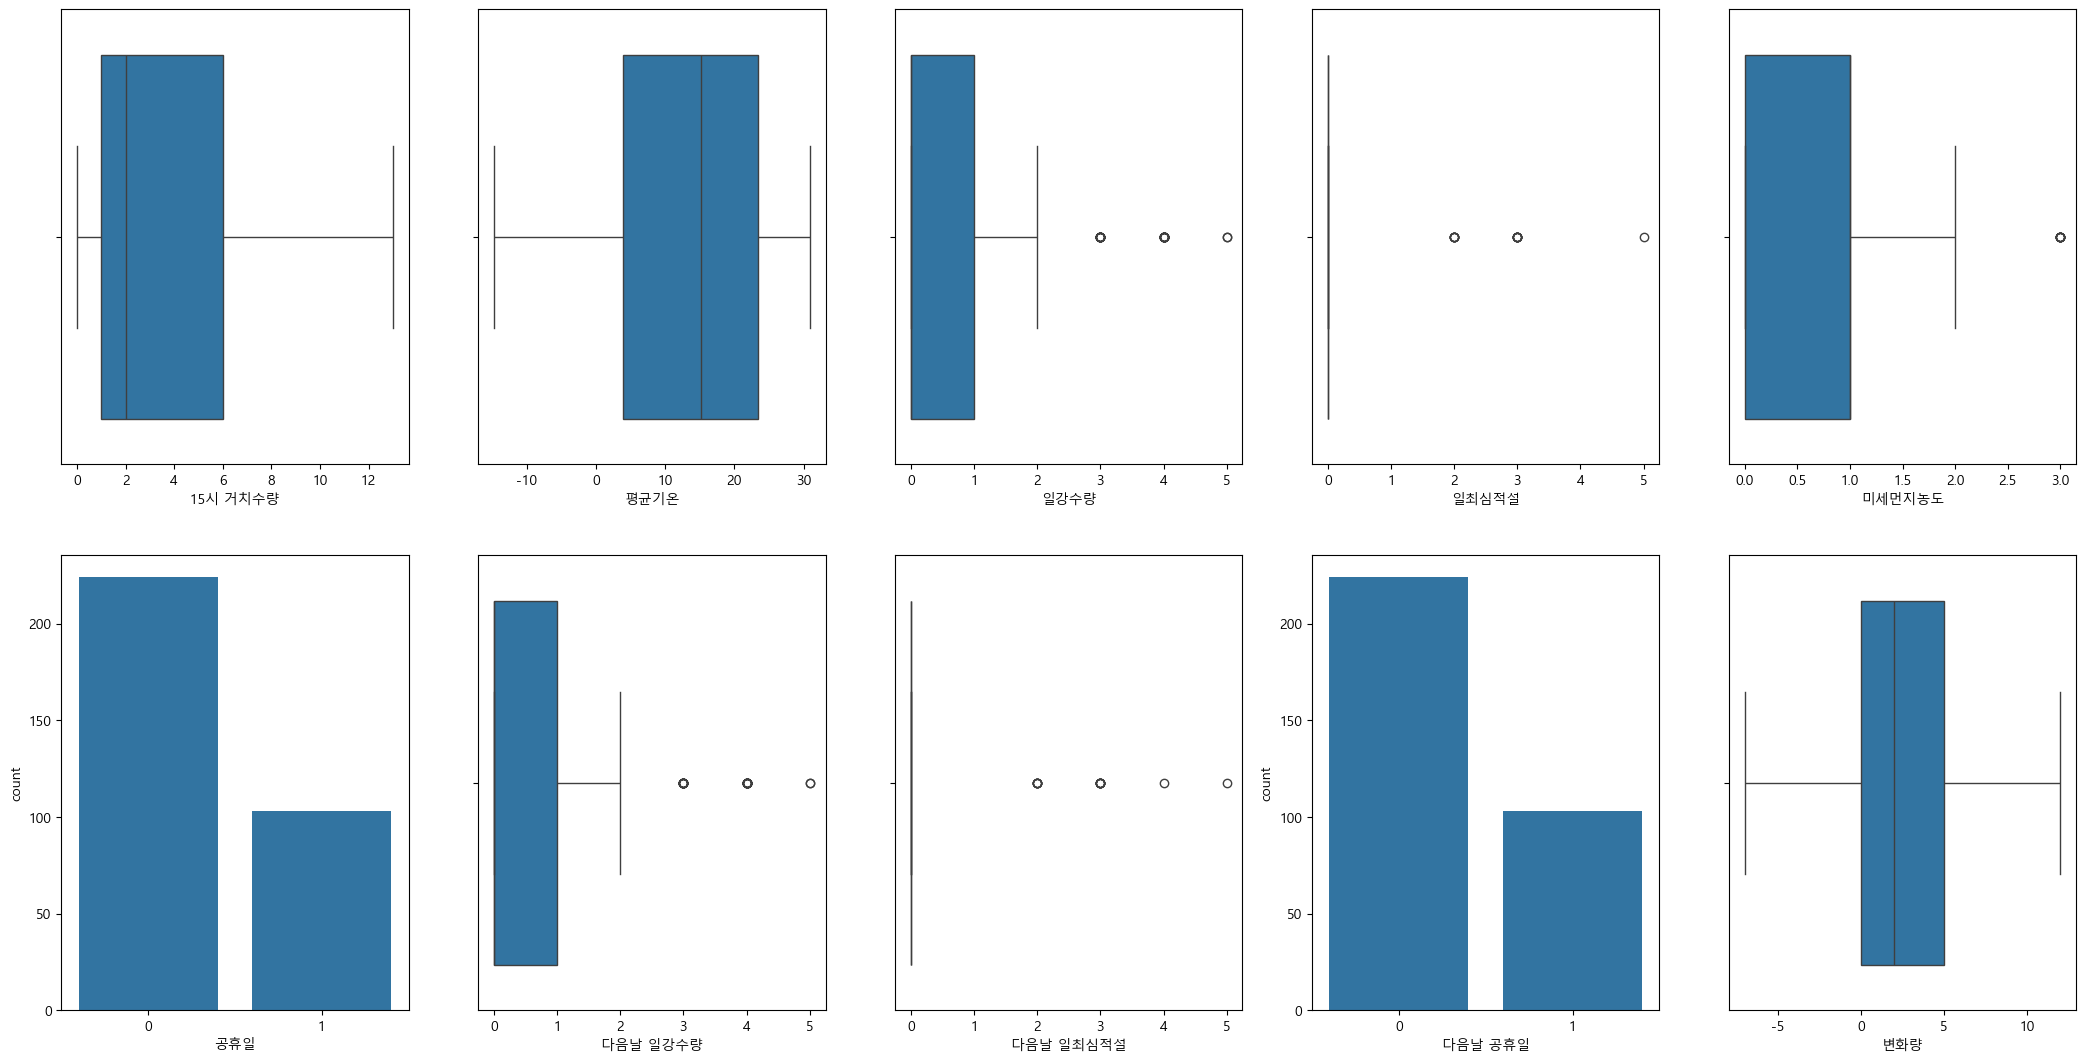

In [55]:
# 구간화 후 시각화
plt.figure(figsize=(26, 13))
for i, c in enumerate(df.columns):
    plt.subplot(2, 5, i + 1)
    # 연속형 변수의 경우 boxplot
    if df[c].dtype in ['int64', 'float64']:
        sns.boxplot(data=df, x=c)
    # 범주형 변수의 경우 barplot
    else:
        sns.countplot(data=df, x=c)
plt.show()

In [ ]:
# 변수 중요도 확인 결과 일최심적설, 다음날 일최심적설의 기여도가 낮으므로 일강수량, 다음날 일강수량 컬럼에 통합
# 통합 후 성능이 개선되지 않음
df['일강수량'] = df['일강수량'] + df['일최심적설']
df['다음날 일강수량'] = df['다음날 일강수량'] + df['다음날 일최심적설']

In [7]:
# 학습용과 검증용 데이터 분리
# 일최심적설과 다음날 일최심적설 컬럼은 불필요하다고 판단하여 제거
x = df.drop(['변화량', '다음날 8시 거치수량', '일최심적설', '다음날 일최심적설'], axis=1)
y = df[['변화량']]
# 15시 거치수량 값에 예측한 변화량을 더한 값이 다음날 출근시간에 필요한 예상 따릉이 거치수량이며, 이 값이 실제 다음날
yy = df[['다음날 8시 거치수량']]
x_train, x_test, y_train, y_test, yy_train, yy_test = train_test_split(x, y, yy, random_state=12)

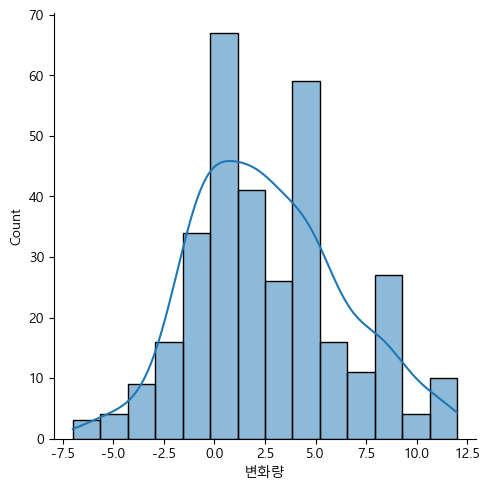

In [ ]:
# 타깃값의 정규분포 확인
# 트리기반 모델(rf, xgb)의 경우 정규성이 크게 중요하지 않기 때문에 scaling하지 않음
# (트리기반 모델은 최적의 분할 기준을 찾아 그 기준을 바탕으로 분류해가는 방식이기 때문에 정규성이 중요하지 않음)
sns.displot(data=y, x='변화량', kde=True)

In [ ]:
# 사용 x
# 연속형 변수와 범주형 변수 구분하여 전처리 파이프라인 생성
num_col = x_train.describe(include=['int64', 'float64']).columns.tolist()
cat_col = x_train.describe(include=['object', 'category']).columns.tolist()

# FunctionTransformer() : 아무 전처리도 적용하지 않음
num_pl = make_pipeline(FunctionTransformer())
cat_pl = make_pipeline(FunctionTransformer())

preprocessing_pl = make_column_transformer((num_pl, num_col),
                                           (cat_pl, cat_col))

In [ ]:
# 사용 x
# 학습을 위한 전처리
preprocessing_pl.fit(x_train)
x_train2 = preprocessing_pl.transform(x_train)
x_test2 = preprocessing_pl.transform(x_test)

### 모델 학습

rf (적은 데이터 수에 적합, 이상치에 덜 민감함)
, xg

In [8]:
rf = RandomForestRegressor(random_state=12,
                           n_estimators=163,
                           max_depth=47,
                           min_samples_split=5,
                           min_samples_leaf=2,
                           max_features=0.2644327508721473)
rf.fit(x_train, y_train)

c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=47, max_features=0.2644327508721473,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=163,
                      random_state=12)

In [9]:
xgb = XGBRegressor(random_state=12,
                   eval_metric='rmse',
                   eta=0.6034056031985222,
                   n_estimators=1652,
                   max_depth=6,
                   min_child_weight=17,
                   gamma=8,
                   subsample=0.9806884001773922,
                   colsample_bytree=0.0030001500815499266,
                   reg_lambda=0.019704900528900726,
                   alpha=0.02594988247663179
                   )
xgb.fit(x_train, y_train)

XGBRegressor(alpha=0.02594988247663179, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.0030001500815499266, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.6034056031985222, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=8, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=17, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1652, ...)

하이퍼파라미터 튜닝

In [16]:
def objective_rf(trial: Trial):
    params = {'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
              'max_depth': trial.suggest_int('max_depth', 5, 50),
              'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
              'max_features': trial.suggest_float('max_features', 0.1, 1.0),
              'random_state': 12}
    model = RandomForestRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = mean_squared_error(y_test, y_pred) ** 0.5
    return score

sampler = TPESampler(seed=12)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective_rf, n_trials=100)

print('Best RMSE:', study.best_value)
print('Best params:', study.best_trial.params)

[I 2025-07-03 17:56:37,109] A new study created in memory with name: no-name-29559744-d68a-4459-8074-9832c0ce7992
c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-03 17:56:37,674] Trial 0 finished with value: 3.104739550147135 and parameters: {'n_estimators': 393, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.11311746623687771}. Best is trial 0 with value: 3.104739550147135.
c:\Users\xjrma\anaconda3\envs\home\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-03 17:56:40,037] Trial 1 finished with value: 3.188203438

Best RMSE: 3.040024603019491
Best params: {'n_estimators': 163, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.2644327508721473}


In [ ]:
def objective_xgb(trial: Trial):
    params = {'eta': trial.suggest_float('eta', 0, 1),
              'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
              'max_depth': trial.suggest_int('max_depth', 3, 30),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
              'gamma': trial.suggest_int('gamma', 0, 10),
              'subsample': trial.suggest_float('subsample', 0, 1),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'alpha': trial.suggest_float('alpha', 0, 1),
              'random_state': 12}
    
    model = XGBRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = mean_squared_error(y_test, y_pred) ** 0.5
    return score

sampler = TPESampler(seed=12)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective_xgb, n_trials=100)

print('Best RMSE: ', study.best_value)
print('Best params:', study.best_params)

[I 2025-07-03 18:10:01,885] A new study created in memory with name: no-name-71fe533f-de09-4359-80d5-113c7426cc64
[I 2025-07-03 18:10:02,843] Trial 0 finished with value: 3.8155945272892517 and parameters: {'eta': 0.15416284237967237, 'n_estimators': 1506, 'max_depth': 10, 'min_child_weight': 11, 'gamma': 0, 'subsample': 0.918747008099885, 'colsample_bytree': 0.9007148541170122, 'reg_lambda': 0.03342142762634459, 'alpha': 0.9569493362751168}. Best is trial 0 with value: 3.8155945272892517.
[I 2025-07-03 18:10:02,991] Trial 1 finished with value: 3.7669605719981685 and parameters: {'eta': 0.13720932135607644, 'n_estimators': 639, 'max_depth': 19, 'min_child_weight': 19, 'gamma': 9, 'subsample': 0.002259233518513537, 'colsample_bytree': 0.5212260272202929, 'reg_lambda': 0.5520376332645666, 'alpha': 0.4853774136627097}. Best is trial 1 with value: 3.7669605719981685.
[I 2025-07-03 18:10:03,190] Trial 2 finished with value: 1072.0929880378847 and parameters: {'eta': 0.7681341540644223, 'n_

Best RMSE:  3.0836633728997205
Best params: {'eta': 0.6034056031985222, 'n_estimators': 1652, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 8, 'subsample': 0.9806884001773922, 'colsample_bytree': 0.0030001500815499266, 'reg_lambda': 0.019704900528900726, 'alpha': 0.02594988247663179}


### 모델 평가

In [15]:
def eval_func(model, x_test, y_test, yy_test):    
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # 독립변수에 있는 15시 거치수량 값
    x_test = x_test.reset_index(drop=True)
    # 모델로 예측한 변화량 값
    y_pred = pd.DataFrame(y_pred, columns=['예측 변화량']).reset_index(drop=True)
    result_df = pd.concat([x_test, y_pred], axis=1)

    # 다음날 8시 거치수량을 예측하기 위해서 테스트셋의 15시 거치수량에 예측한 변화량을 더해줌
    result_df['예측 다음날 8시 거치수량'] = round(result_df['15시 거치수량'] + result_df['예측 변화량'])

    # 예측값과의 오차를 계산하기 위해서 yy_test에서 실제 다음날 8시 거치수량을 가져오기 
    yy_test = yy_test.reset_index(drop=True)
    result_df = pd.concat([result_df, yy_test], axis=1)
    result_df['오차'] = abs(result_df['다음날 8시 거치수량'] - result_df['예측 다음날 8시 거치수량'])
    avg_diff = round(result_df['오차'].sum() / len(result_df), 1)
    
    print(f'{model}\n------------------------------------------------------------\n{"rmse":<4} : {rmse}\n{"r2":<4} : {r2}\n{"mae":<4} : {avg_diff}')
    return result_df

In [11]:
# 평가할 모델 설정 (rf, xgb)
model = rf

eval_func(model, x_test, y_test, yy_test)

RandomForestRegressor(max_depth=47, max_features=0.2644327508721473,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=163,
                      random_state=12)
------------------------------------------------------------
rmse : 3.040024603019491
r2   : 0.3295117206035254
mae  : 2.4


In [19]:
# 변수중요도 확인
df_importance = pd.DataFrame({'feature':x_train.columns,
                              'importance':model.feature_importances_})
df_importance['percentage'] = round(df_importance['importance'] / df_importance['importance'].sum() * 100, 2)

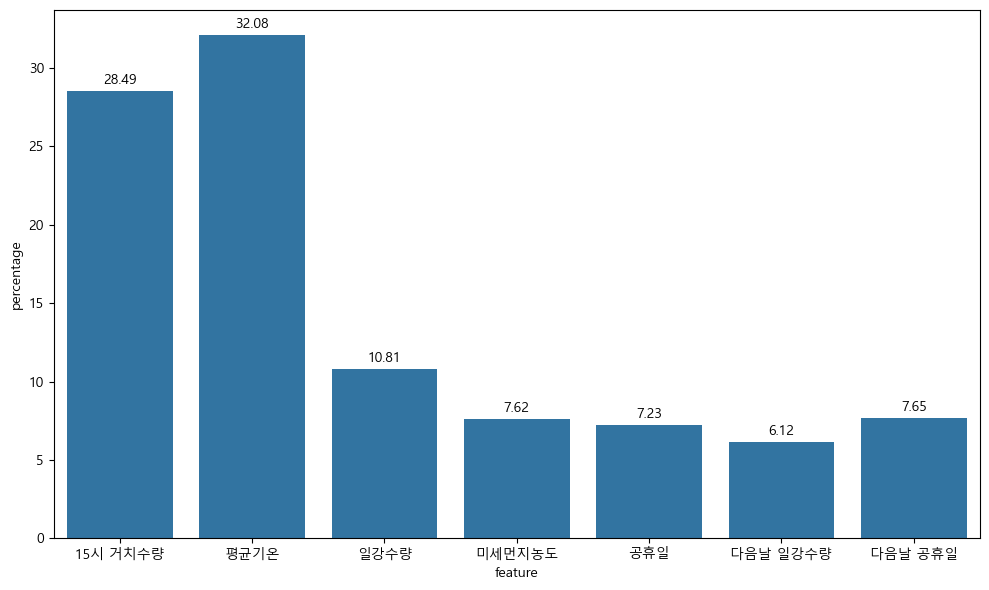

In [20]:
# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 6))
bar = sns.barplot(data=df_importance, x='feature', y='percentage', ax=ax)
ax.bar_label(bar.containers[0], padding=3)
plt.tight_layout()
plt.show()

In [16]:
result_df = eval_func(model, x_test, y_test, yy_test)
result_df

RandomForestRegressor(max_depth=47, max_features=0.2644327508721473,
                      min_samples_leaf=2, min_samples_split=5, n_estimators=163,
                      random_state=12)
------------------------------------------------------------
rmse : 3.040024603019491
r2   : 0.3295117206035254
mae  : 2.4


,15시 거치수량,평균기온,일강수량,미세먼지농도,공휴일,다음날 일강수량,다음날 공휴일,예측 변화량,예측 다음날 8시 거치수량,다음날 8시 거치수량,오차
0,7,1.3,0,0,0,0,0,0.820145,8.0,7,1.0
1,1,28.4,0,0,0,0,0,5.564876,7.0,9,2.0
2,3,2.8,0,1,1,0,1,1.537229,5.0,11,6.0
3,1,1.2,0,1,0,0,0,2.681019,4.0,5,1.0
4,2,11.4,0,2,1,3,0,2.438515,4.0,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
77,7,0.9,0,2,0,0,0,0.683421,8.0,7,1.0
78,0,1.7,0,2,1,0,0,1.562839,2.0,1,1.0
79,7,11.7,0,2,0,2,0,2.149757,9.0,9,0.0
80,4,-14.7,0,0,1,0,0,0.061163,4.0,3,1.0


In [22]:
result_df.sort_values(by='오차', ascending=False).tail(40)

,15시 거치수량,평균기온,일강수량,미세먼지농도,공휴일,다음날 일강수량,다음날 공휴일,예측 변화량,예측 다음날 8시 거치수량,다음날 8시 거치수량,오차
43,5,1.3,0,3,1,0,0,1.376881,6.0,4,2.0
47,8,24.2,4,1,0,2,0,1.643426,10.0,8,2.0
38,0,28.2,0,0,1,4,0,4.157548,4.0,6,2.0
67,0,-7.7,0,0,0,1,0,3.300702,3.0,1,2.0
0,7,1.3,0,0,0,0,0,0.820145,8.0,7,1.0
3,1,1.2,0,1,0,0,0,2.681019,4.0,5,1.0
10,9,8.3,4,0,0,2,1,1.060051,10.0,9,1.0
13,1,5.9,0,1,1,0,0,1.470127,2.0,1,1.0
77,7,0.9,0,2,0,0,0,0.683421,8.0,7,1.0
49,6,5.9,0,1,0,4,0,2.982742,9.0,10,1.0
